# Tracking wrinkles in webs
### For questions/concerns contact Robert Hutton, sam@samhutton.net 


- The videos are recorded from an arial perspective, which allows the camera to see the downstream roller and the upstream roller, as well as the "troughs" in-between


- We will be requiring the following libraries:

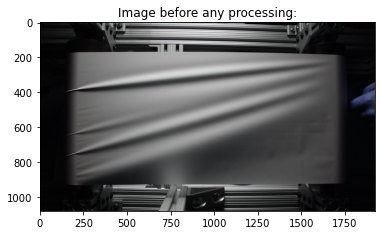

In [124]:
import csv
import cv2 as cv
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pandas import DataFrame, Series
import pims
import trackpy as tp
import moviepy
import skimage.exposure as exposure
import seaborn as sns
import glob
import os,sys

#this is just an example frame
example = cv.imread('example.png')
plt.imshow(example,cmap = 'gray') 
plt.title('Image before any processing:')
plt.show()

First, use FFMPEG to slice the video into frames saved as png image files. save to the working directory.

use command: ffmpeg -i input/input.mov -vf fps=1/4 output/%03d.png

change the second "input" to the movie file name.

It is important to note the width of the span in the file name!! since the roller is no longer in the picture as a calibration distance.

- first we define a class that will define a sequence of images as an instance. 
- the methods will be the image processing functions that we want to use on the sequence.

In [125]:
class ImageSeries():
    def __init__(self, location): #use init function to define the sequence of images as self.sequence using glob.glob in the directory where the images are
        self.images = []
        self.sequence = sorted(glob.glob(f"{location}/*.png")) #create a sequence of images where the images are represented by their filename
        for image in self.sequence:
            self.images.append(cv.imread(str(image))) #create a list of images where the images are represented by the actual image arrays

class ProcessImage(ImageSeries):
    def blur(self, kernel_size): #function to apply a gaussian blur to the image
        blurred_images = []
        for image in self.images: #step through each image in the input series
            blurred_images.append(cv.blur(image,(kernel_size,kernel_size))) #use openCV gaussian blur to apply gaussian blur
        self.images = blurred_images

    def gamma(self, gamma_size): #produce a gamma table based on the input value and use the table to change the gamma of the image
        invGamma = 1 / gamma_size #invert the gamma value to build table from
        table = [((i / 255) ** invGamma) * 255 for i in range(256)] #construct gamma table
        table = np.array(table, np.uint8) #store table as an array
        gamma_adjust = []
        for image in self.images: #apply the gamma table to each image in the sequence by using openCV LUT
            gamma_adjust.append(cv.LUT(image, table))
        self.images = gamma_adjust

    def sharpen(self, sharpening_kernel_key): #sharpen the images by a given kernel key by convolving the image with a sharpening kernel
        sharpened_images = []
        for image in self.images:   
            kernel = np.array([ [-1,-1,-1], #the kernel is constructed of -1's with the sharpening key in the center
                            [-1, sharpening_kernel_key,-1],
                            [-1,-1,-1]])
            sharpened_images.appaend*(cv.filter2D(image, -1, kernel)) #apply the convulution to the image

    def canny(self, threshold1, threshold2): #canny edge filter grabs edges from each image in the series and dumps the edges into self.edges
        i = 0 
        self.canny_edges = []
        for image in self.images: 
            image = cv.cvtColor(image, cv.COLOR_BGR2GRAY) #image must be this format for canny edge from openCV
            self.canny_edges.append(cv.Canny(image, threshold1, threshold2)) #append self.cannyedges along with self.images
            cv.imwrite('output_sequence/'+f"canny_{i}.png", self.canny_edges[i])
            i += 1
        plt.imshow(self.canny_edges[65],cmap = 'gray') #plot the last image processed for quick visual check
        plt.title('Image post processing:')
        plt.show()

    def crop_span(self): #crops the frames produced by canny algorith based on the top and bottom edges of the span, uses spacing of gradients
        frame = self.canny_edges[round(len(self.images)/2)] #grab the middle frame as our crop set
        x_center = int(1920/2)  #assume input footage is 1920x1080
        y,x = frame.shape
        self.span_top_edge = 0 #initally, set the crop parameters to the frame size (no crop)
        self.span_bottom_edge = 1080
        for j in range(int(1080/2)):
            if frame[j, x_center] > 125: #perform a linear search for >0 pixel values in the canny image
                self.span_top_edge = j #the last >0 pixel value bocomes the top edge
        for l in range(int(1080/2)):
            if frame[1079-l,x_center] > 125: #same logic here as above but inverted to search from the bottom
                self.span_bottom_edge = 1080 - l
        crop1 = []
        crop2 = []
        for image in self.canny_edges:
            crop1.append(image[self.span_top_edge:self.span_bottom_edge, 0:1920])
        for image in self.images:
            crop2.append(image[self.span_top_edge:self.span_bottom_edge, 0:1920])
        self.images = crop2
        self.canny_edges = crop1
        

    def convert_binary(self):
        i = 0
        for image in self.canny_edges:
            #im_gray = cv.imread(image, cv.IMREAD_GRAYSCALE)
            (thresh, self.canny_edges[i]) = cv.threshold(self.canny_edges[i], 125, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)
            i+=1
        
    def hough_lines(self, thresh, min_len, min_sep): #hough lines via openCV calculated probablistic lines in the image based on input which is edges
        i = 0
        self.linesP = []
        for image in self.images:
            self.linesP.append(cv.HoughLinesP(self.canny_edges[i], 1, np.pi/360, thresh, min_len, min_sep)) #for each image, append the lines to a blank list self.lines
            i += 1
        
    def filter_lines(self): #here we filter the lines based on slope, strength, spacing, etc
        self.strong_lines = np.zeros([4,1,2])
        minLineLength = 2
        maxLineGap = 10
        n2 = 0
        for n1 in range(0,len(self.lines)):
            for rho,theta in self.lines[n1]:
                if n1 == 0:
                    self.strong_lines[n2] = self.lines[n1]
                    n2 = n2 + 1
                else:
                    if rho < 0:
                        rho*=-1
                        theta-=np.pi
                        closeness_rho = np.isclose(rho,self.strong_lines[0:n2,0,0],atol = 10)
                        closeness_theta = np.isclose(theta,self.strong_lines[0:n2,0,1],atol = np.pi/36)
                        closeness = np.all([closeness_rho,closeness_theta],axis=0)
                        if not any(closeness) and n2 < 4:
                            self.strong_lines[n2] = self.lines[n1]
                            n2 = n2 + 1

    def overlay_lines(self): #here we draw the lines on the original set of images
        i = 0
        self.slopes = []
        for image in self.images:
            for line in self.linesP[i]:
                x1, y1, x2, y2 = line[0]
                print(image.shape)
                if y1>50 and y2<(image.shape[0]-50):
                    cv.line(image, (x1, y1), (x2, y2), (0, 0, 255), 2)
            i+=1
        padded = []
        for image in self.images:
            padded.append(cv.copyMakeBorder(image, self.span_top_edge, 1080-self.span_bottom_edge, 0, 0, cv.BORDER_CONSTANT,value=[0,0,0]))
        self.images = padded

    def show_series(self):
        for image in self.images:
            plt.imshow(image,cmap = 'gray') #plot the last image processed for quick visual check
        plt.title('Image post processing:')
        plt.show()
        
    def write_series(self): #method is called at the end of an operation chain to write the final images to a new directory
        i = 0
        for image in self.images: #loop through each image in the current series
            i = i+1
            cv.imwrite('output_sequence/'+f"output_{i}.png", image) #write the new image to the directory with incrementing, sequential filenames

    def seperate_slopes(self): #seperated the slope evoluton of each wrinkle into a separate list for obvious reasons 
        slopes2 = []
        i_list = []
        for i in self.slopes:
            if i[0] not in i_list:
                print(i[0])
                i_list.append(i[0])
                slopes2.append(i[1])
    
            

- please note that the class organization causes the time complexity to go as O(m*n) where m is the number of methods called on the series. For massive series, it is possible to reorganize desired methods into a single function such that the complexity is simply O(n)

- now we apply the processing steps to all of the images in the series

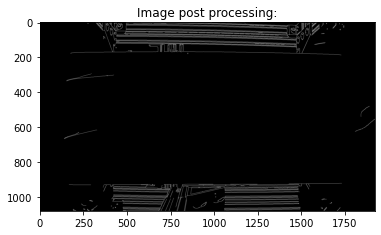

x = 1920, y = 1080
(759, 1920, 3)
(759, 1920, 3)
(759, 1920, 3)
(759, 1920, 3)
(759, 1920, 3)
(759, 1920, 3)
(759, 1920, 3)
(759, 1920, 3)
(759, 1920, 3)
(759, 1920, 3)
(759, 1920, 3)
(759, 1920, 3)
(759, 1920, 3)
(759, 1920, 3)
(759, 1920, 3)
(759, 1920, 3)
(759, 1920, 3)
(759, 1920, 3)
(759, 1920, 3)
(759, 1920, 3)
(759, 1920, 3)
(759, 1920, 3)
(759, 1920, 3)
(759, 1920, 3)
(759, 1920, 3)
(759, 1920, 3)
(759, 1920, 3)
(759, 1920, 3)
(759, 1920, 3)
(759, 1920, 3)
(759, 1920, 3)
(759, 1920, 3)
(759, 1920, 3)
(759, 1920, 3)
(759, 1920, 3)
(759, 1920, 3)
(759, 1920, 3)
(759, 1920, 3)
(759, 1920, 3)
(759, 1920, 3)
(759, 1920, 3)
(759, 1920, 3)
(759, 1920, 3)
(759, 1920, 3)
(759, 1920, 3)
(759, 1920, 3)
(759, 1920, 3)
(759, 1920, 3)
(759, 1920, 3)
(759, 1920, 3)
(759, 1920, 3)
(759, 1920, 3)
(759, 1920, 3)
(759, 1920, 3)
(759, 1920, 3)
(759, 1920, 3)
(759, 1920, 3)
(759, 1920, 3)
(759, 1920, 3)
(759, 1920, 3)
(759, 1920, 3)
(759, 1920, 3)
(759, 1920, 3)
(759, 1920, 3)
(759, 1920, 3)
(759, 

In [126]:
sequence1 = ProcessImage('input_sequence')
#sequence1.blur(kernel_size = 5) #use value between 3 and 9
#sequence1.gamma(2.0) #use a value between 0.5 and 2
sequence1.canny(threshold1 = 155/3, threshold2 = 155)
sequence1.crop_span() #crops the image to the vertical edges of the span
sequence1.hough_lines(thresh = 0, min_len = 0, min_sep = 0)
sequence1.overlay_lines()
sequence1.write_series()

- Then write the sequence back to a video using 
- $ ffmpeg -framerate 1 -i happy%d.jpg -c:v libx264 -r 30 output.mp4
